In [11]:
import os
import pickle
from sparta.Auxil.PeriodicityDetector import PeriodicityDetector
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template
from sparta.Auxil.TimeSeries import TimeSeries
from sparta.Observations import Observations
import numpy as np
import pandas as pd


In [12]:
# DATA PARAMETERS

survey = "HERMES" # survey name
sample_rate = 1 # sample rate of the data
min_wv = 4400 # minimum wavelength of the data
max_wv = 4600 # maximum wavelength of the data
spec_dir = r"C:\Users\kentb\Desktop\PDM\data\Hermes\spectra\RRLyr_Hermes_spectra" # directory of the spectrum
rv_dir = r"C:\Users\kentb\Desktop\PDM\data\Hermes\RV\RRLyr_Hermes.csv" # directory of the RVs
results_dir = r"C:\Users\kentb\Desktop\PDM\data\products\Hermes\."

In [13]:
obs_data = Observations(survey=survey, sample_rate=sample_rate, min_wv=min_wv, max_wv=max_wv,
                        target_visits_lib=spec_dir)
df = pd.read_csv(rv_dir)
rv = df.rv.astype(float).values
e_rv = df.rv_err.astype(float).values
times = df.bjd.astype(float).values
times = times - int(min(times))

let's goooo
Using target_visits_lib: C:\Users\kentb\Desktop\PDM\data\Hermes\spectra\RRLyr_Hermes_spectra
Selected directory: C:\Users\kentb\Desktop\PDM\data\Hermes\spectra\RRLyr_Hermes_spectra
00478488_HRF_OBJ_ext_CosmicsRemoved_log_merged_c.fits
00478494_HRF_OBJ_ext_CosmicsRemoved_log_merged_c.fits
00478500_HRF_OBJ_ext_CosmicsRemoved_log_merged_c.fits
00478507_HRF_OBJ_ext_CosmicsRemoved_log_merged_c.fits
00478508_HRF_OBJ_ext_CosmicsRemoved_log_merged_c.fits
00478515_HRF_OBJ_ext_CosmicsRemoved_log_merged_c.fits
00478516_HRF_OBJ_ext_CosmicsRemoved_log_merged_c.fits
00478520_HRF_OBJ_ext_CosmicsRemoved_log_merged_c.fits
00478521_HRF_OBJ_ext_CosmicsRemoved_log_merged_c.fits
00478527_HRF_OBJ_ext_CosmicsRemoved_log_merged_c.fits
00478528_HRF_OBJ_ext_CosmicsRemoved_log_merged_c.fits
00478531_HRF_OBJ_ext_CosmicsRemoved_log_merged_c.fits
00478533_HRF_OBJ_ext_CosmicsRemoved_log_merged_c.fits
00478534_HRF_OBJ_ext_CosmicsRemoved_log_merged_c.fits
00478536_HRF_OBJ_ext_CosmicsRemoved_log_merged_c.fi

In [14]:
# Rearrange the RVs with the spectra

obs_data.rearrange_time_series(rv=rv, times=times)

In [15]:
# Preprocess the spectra

for i in obs_data.time_series.vals:
    i = i.SpecPreProccess()

In [16]:
# PERIODOGRAM PARAMETERS

baseline = int(obs_data.time_series.times[-1])
min_freq = 1/20 # Or maybe 1/2/baseline to be sure but let's test it that way.
max_freq = 2 # we don't expect more than one pulsation every two day so should be alright.
freq_range = (min_freq, max_freq) # frequency range of the periodograms
points_per_peak = 5
periodogram_grid_resolution = 3000#points_per_peak*max_freq*baseline # frequency resolution of the periodograms

In [17]:
# Choosing frequency range and frequency resolution for the periodograms.
obs_data.initialize_periodicity_detector(freq_range=freq_range,
                                        periodogram_grid_resolution=periodogram_grid_resolution)

In [18]:
obs_data.periodicity_detector.calc_GLS()

print("GLS done", flush=True)

obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shape")

print("Shape done",flush=True)

obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shift")

print("Shift done",flush=True)

# file = open(os.path.join(results_dir, f"{spec_dir.rsplit('/',maxsplit=1)[-1]}_{str(min_wv)}_{str(max_wv)}.pkl"), 'wb')
# pickle.dump(obs_data, file)
# file.close()

GLS done


Shape done
Shift done


In [19]:
obs_data.periodicity_detector.period_truth = [0.566777]

In [ ]:
Relative error on period:  1.644660382560486e-05
Max shape peak power:  0.6759296492621717

Relative error on period:  1.644660382560486e-05
Max shape peak power:  0.6126771409926308


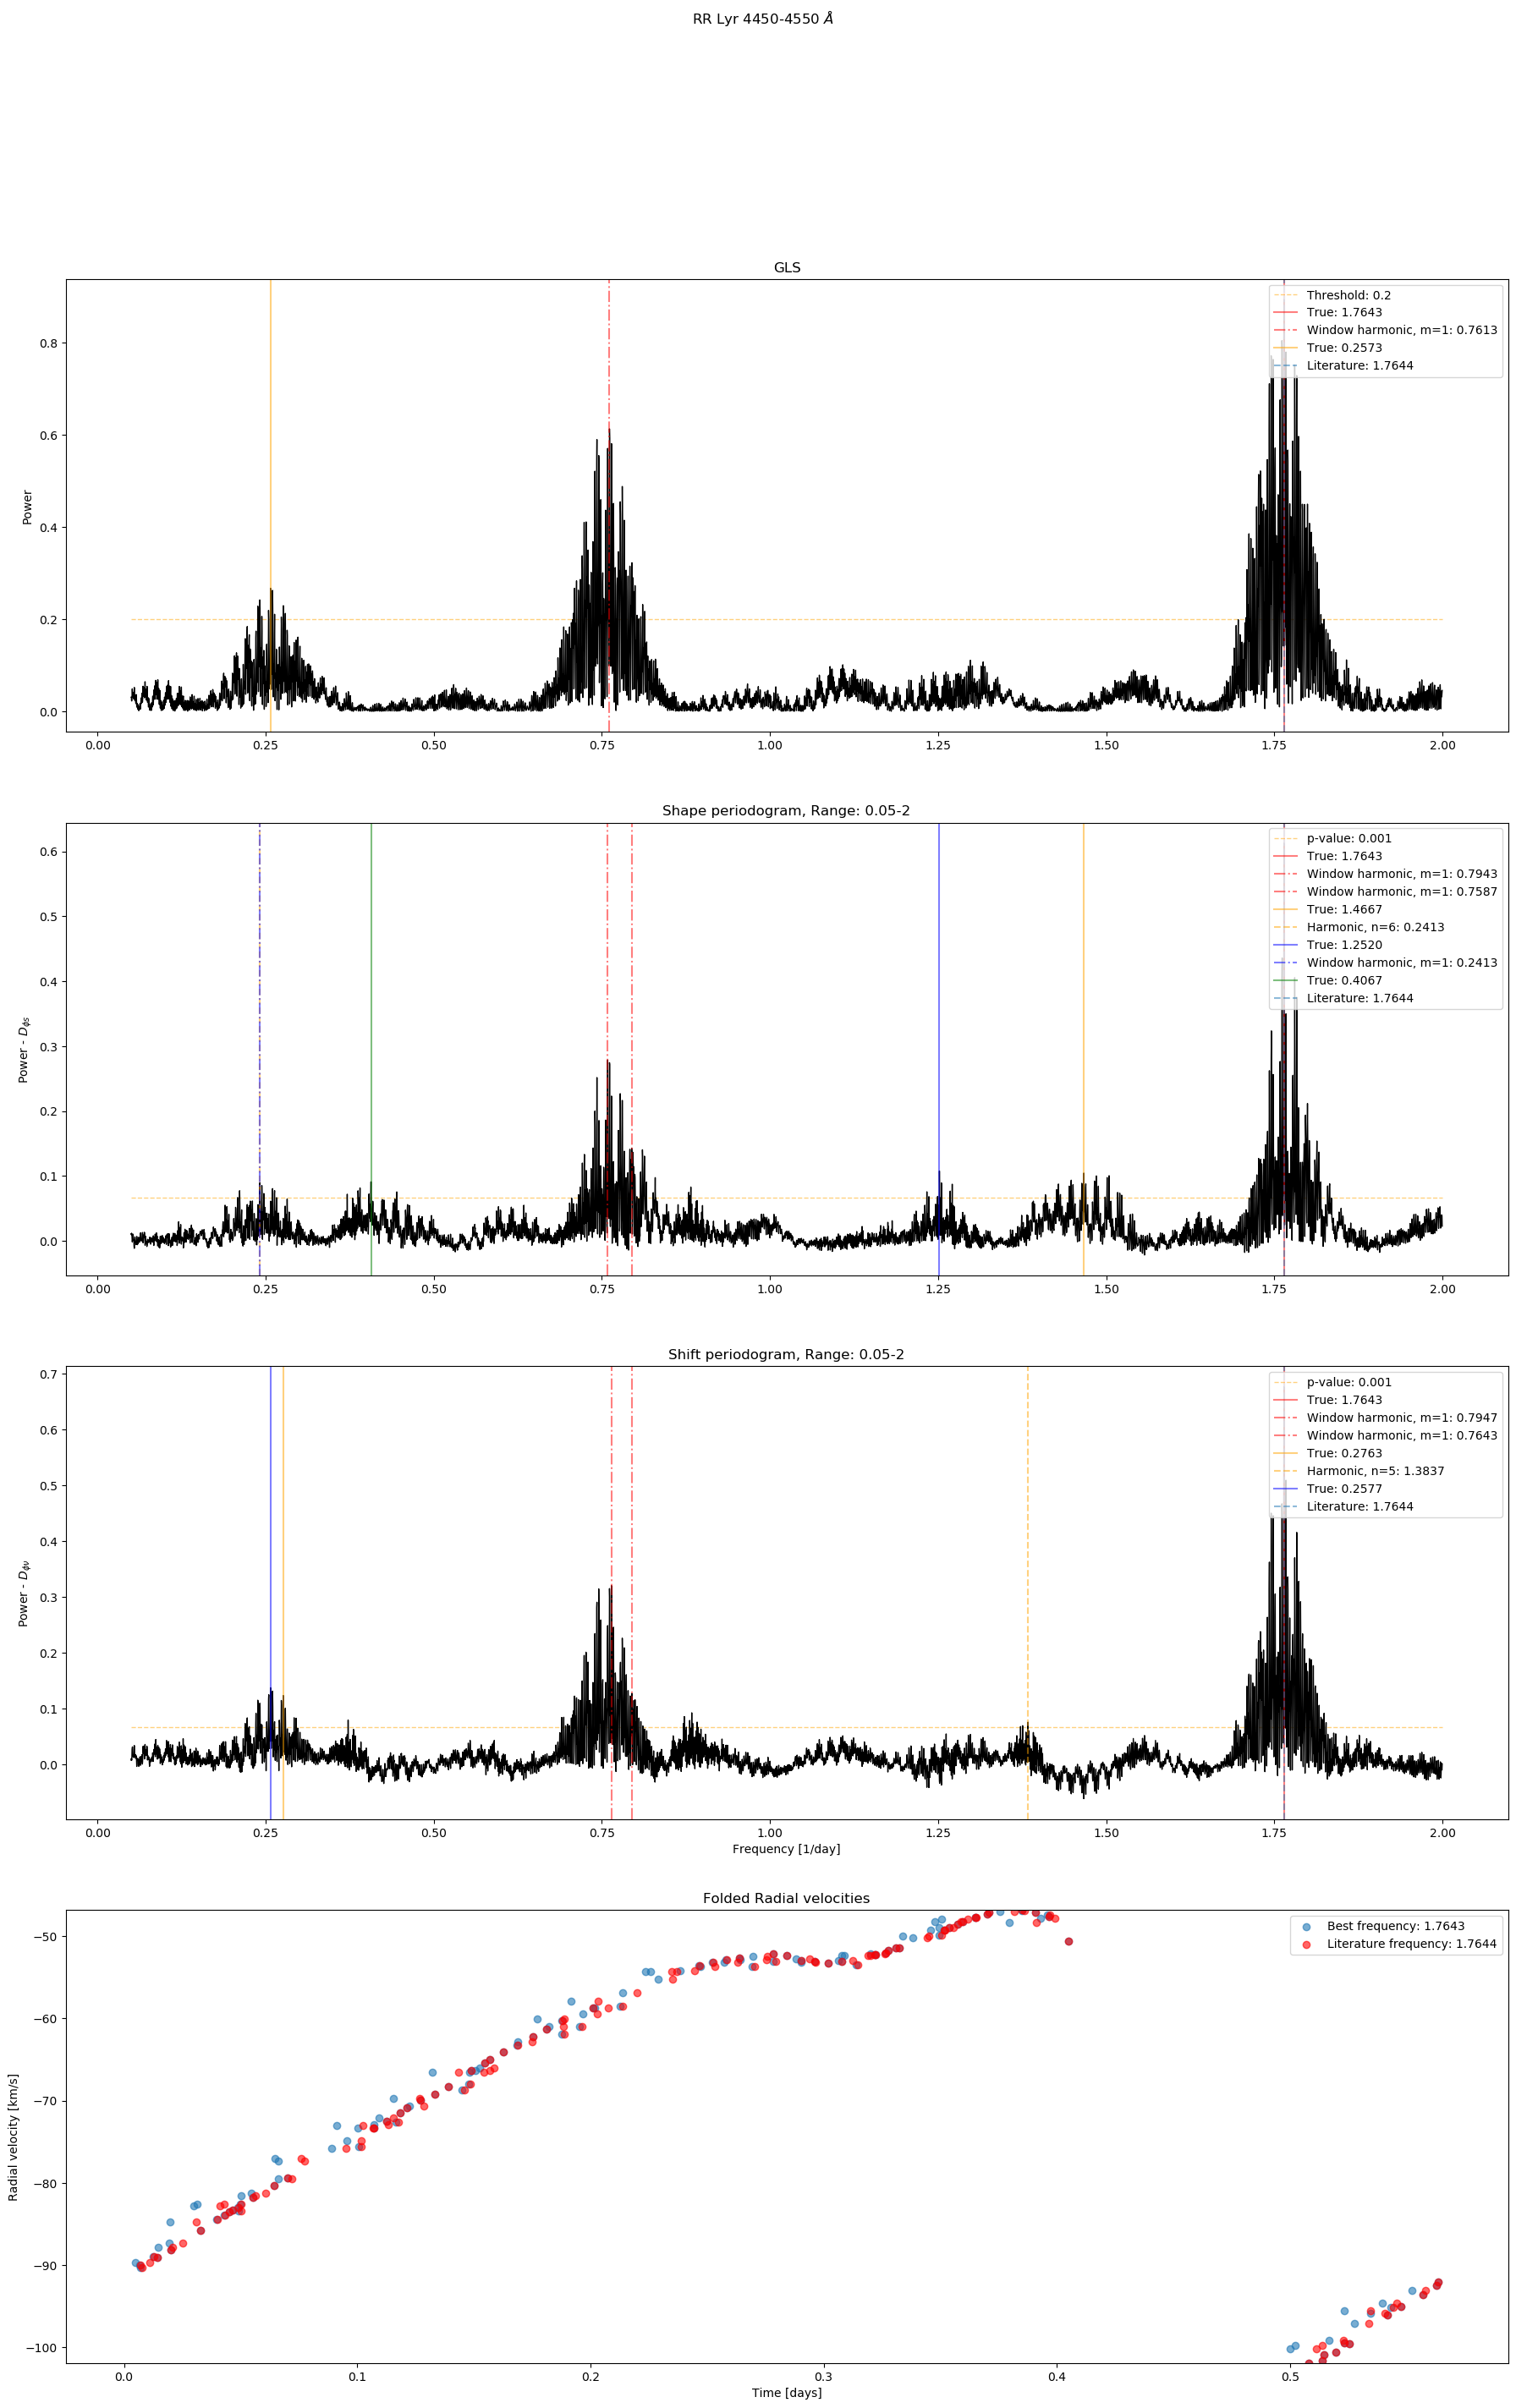

In [20]:
# Plotting the periodograms

obs_data.periodicity_detector.plot_periodograms(annotate_pval=[1e-3], plot_rv=True,title=r"RR Lyr 4450-4550 $\AA$", log_scale=False, plot_peaks=True)

In [2]:
# Load the data

path = os.path.join(r'C:\Users\kentb\Desktop\PDM\data\products\Hermes', 'RRLyr_Hermes_5600_5800.pkl')
file = open(path, "rb")
obs_data = pickle.load(file)
file.close()

In [3]:
obs_data.periodicity_detector.period_truth = [0.566777]
# obs_data.periodicity_detector.period_truth = None

Before cleaning peaks:  [1.76436338 0.76150215 0.25735336]
After removing close peaks:  [1.76436338 0.76150215 0.25735336]
Current peak:  1.7643633762517799
Current peak to compare:  0.7615021459227431
Current harmonic:  2
Current harmonic:  3
Current harmonic:  4
Current harmonic:  5
Current harmonic:  6
Current harmonic:  7
Window harmonic 1 of 1.7643633762517799 found at 0.7615021459227431
[]
Current peak to compare:  0.2573533619456354
Current harmonic:  2
Current harmonic:  3
Current harmonic:  4
Current harmonic:  5
Current harmonic:  6
Current harmonic:  7
this peak is not a harmonic of another peak:  1.7643633762517799
Peaks:  [1.7643633762517799, [], ['1', 0.7615021459227431]]
Current peak:  0.7615021459227431
Current peak to compare:  0.2573533619456354
Current harmonic:  2
Current harmonic:  3
Harmonic 3 of 0.7615021459227431 found at 0.2573533619456354
['3', 0.2573533619456354]
Current harmonic:  4
Current harmonic:  5
Current harmonic:  6
Current harmonic:  7
Current peak:

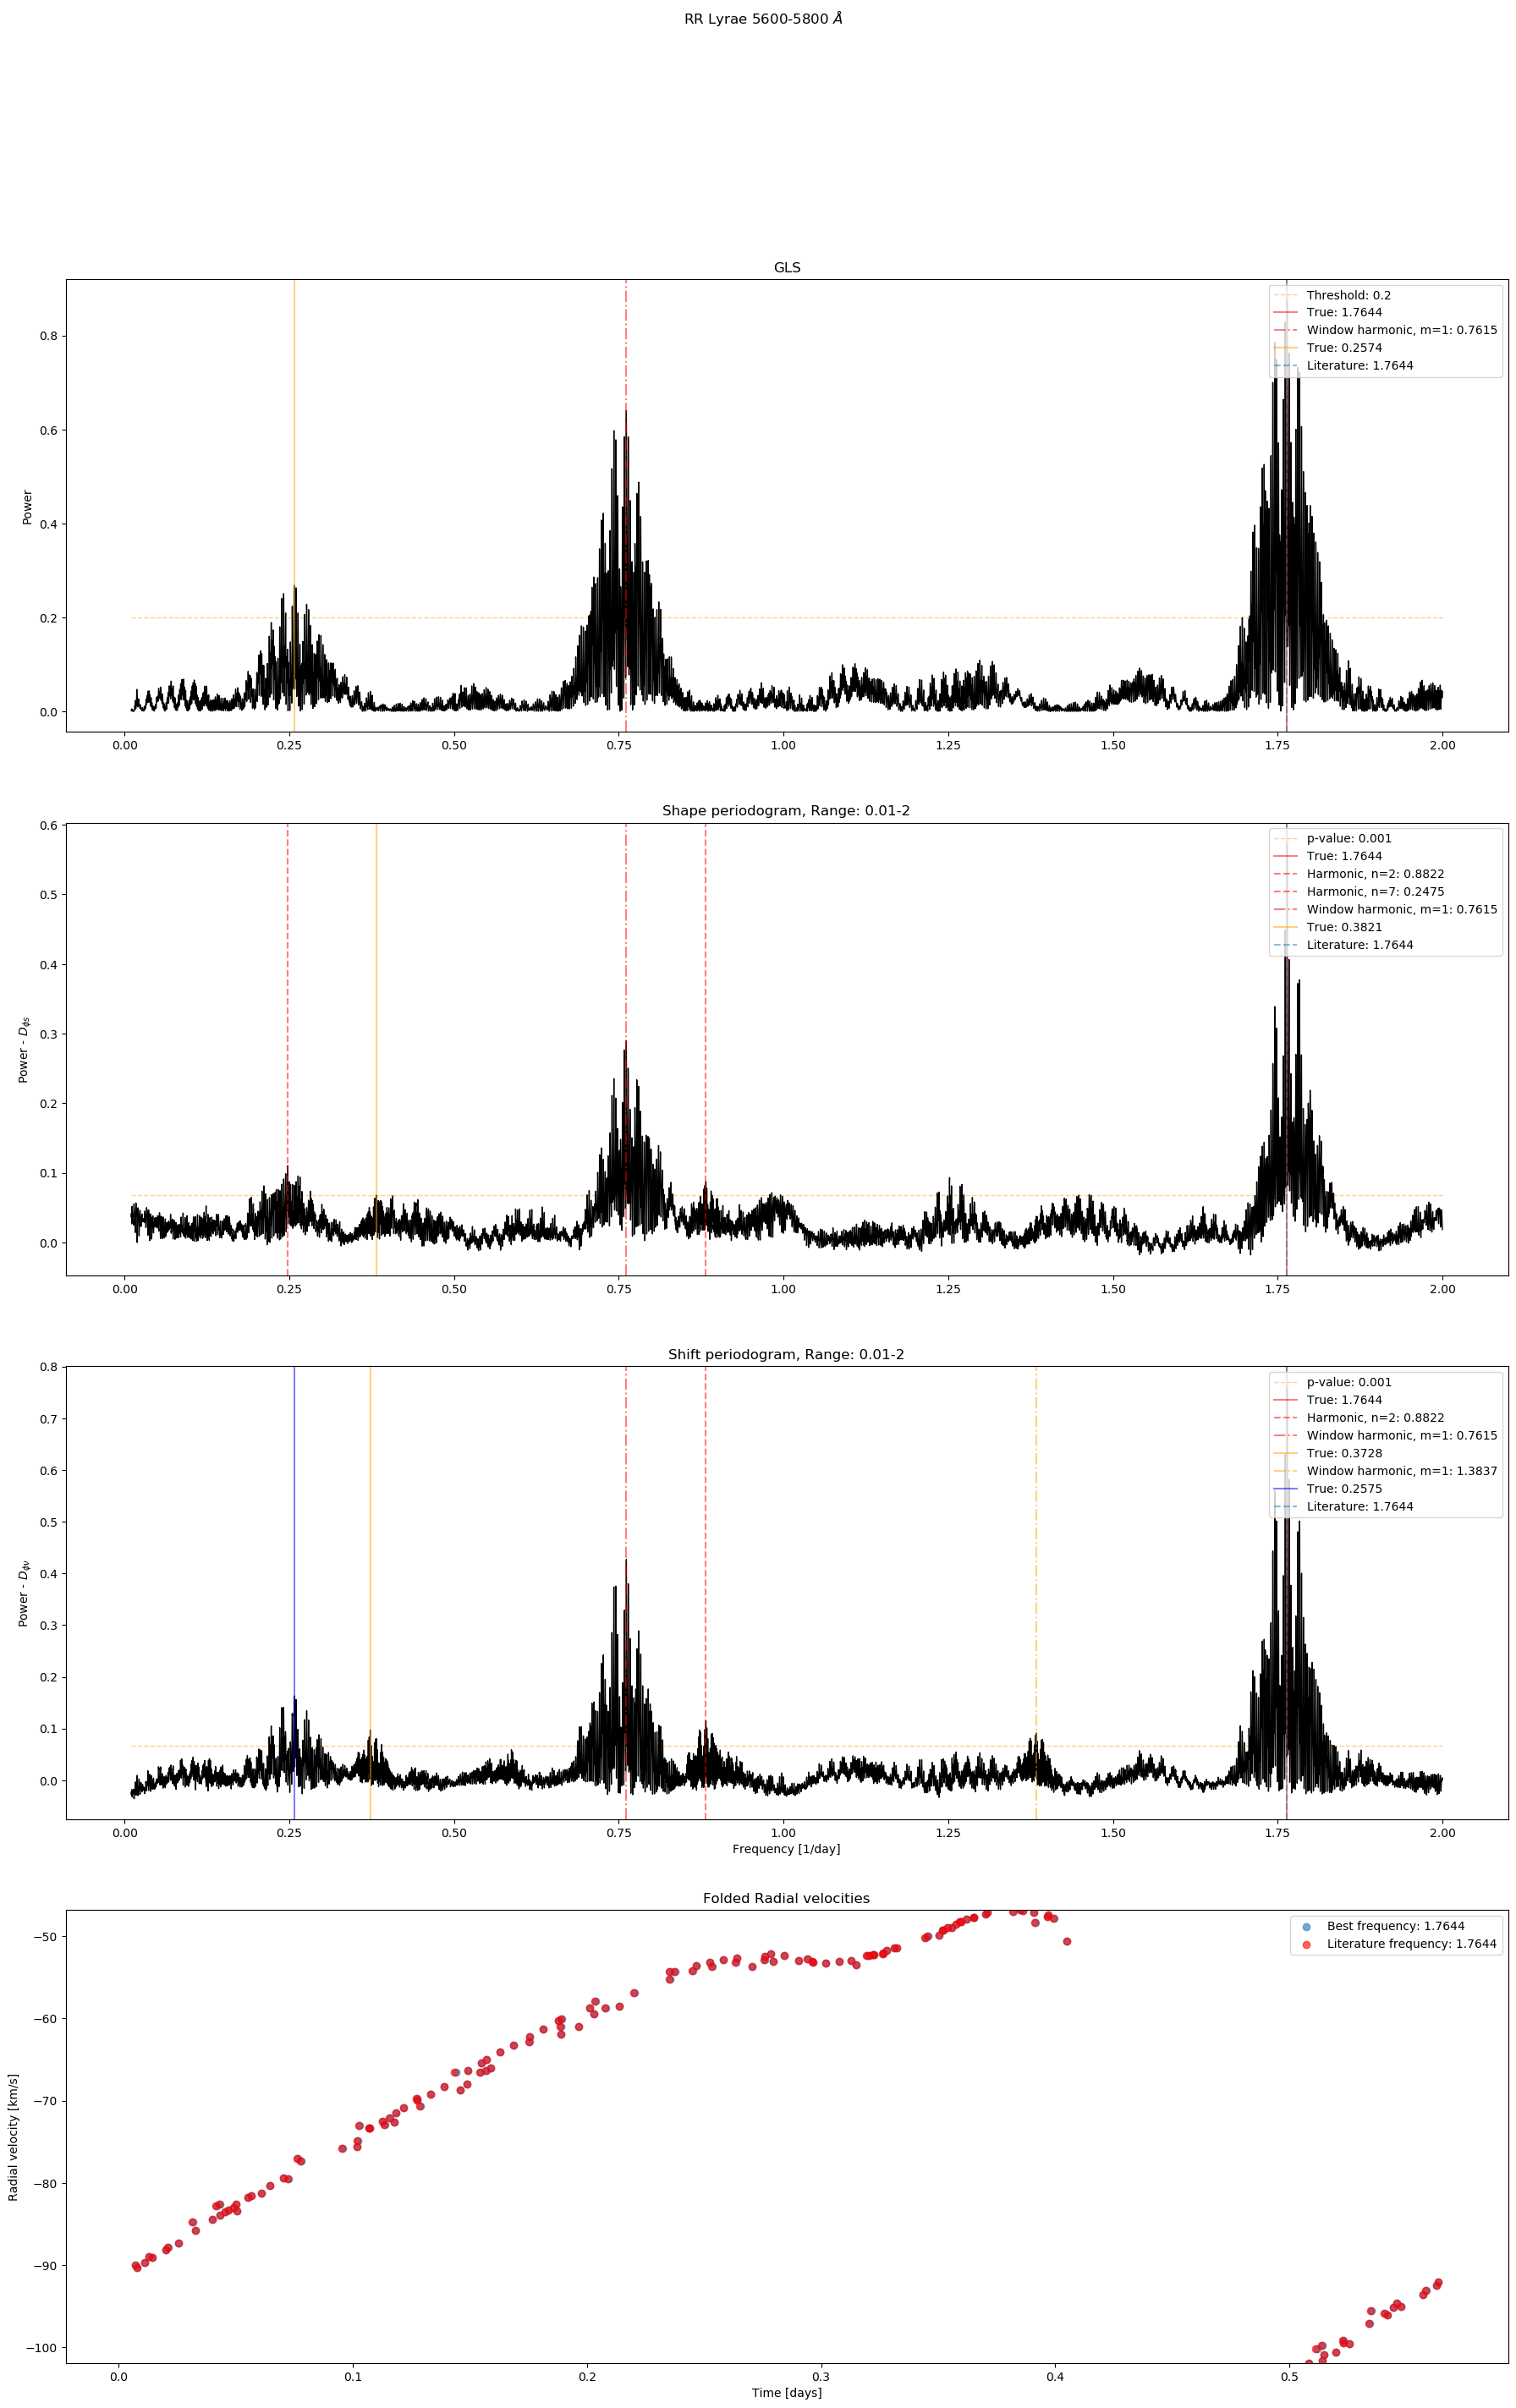

In [4]:
obs_data.periodicity_detector.plot_periodograms(annotate_pval=[1e-3], plot_rv=True,title=r"RR Lyrae 5600-5800 $\AA$", log_scale=False, plot_peaks=True)